## NN6 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN6_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN6_Decile_Signal = pd.DataFrame(index=list_company)
df_NN6_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN6_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # NN6 model
    model_nn6 = Sequential()
    model_nn6.add(Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01), input_shape=(21,)))  # Input layer
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 1
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 2
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 3
    model_nn6.add(Dropout(0.1))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 5
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 6
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(1, activation='linear'))  # Output layer
    model_nn6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn6.fit(X_train, y_train, epochs=6, callbacks=[callback])
    y_fair = model_nn6.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN6_Decile_Signal = df_NN6_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [42]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN6_Quintile_Signal = pd.concat([df_199804_199809, df_NN6_Quintile_Signal, df_202206], axis=1)
df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.fillna(0).T
df_NN6_Quintile_Signal = df_NN6_Quintile_Signal.shift(1).dropna()

df_NN6_Decile_Signal = pd.concat([df_199804_199809, df_NN6_Decile_Signal, df_202206], axis=1)
df_NN6_Decile_Signal = df_NN6_Decile_Signal.fillna(0).T
df_NN6_Decile_Signal = df_NN6_Decile_Signal.shift(1).dropna()

df_NN6_20_Divided_Signal = pd.concat([df_199804_199809, df_NN6_20_Divided_Signal, df_202206], axis=1)
df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.fillna(0).T
df_NN6_20_Divided_Signal = df_NN6_20_Divided_Signal.shift(1).dropna()

df_NN6_Percentile_Signal = pd.concat([df_199804_199809, df_NN6_Percentile_Signal, df_202206], axis=1)
df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.fillna(0).T
df_NN6_Percentile_Signal = df_NN6_Percentile_Signal.shift(1).dropna()

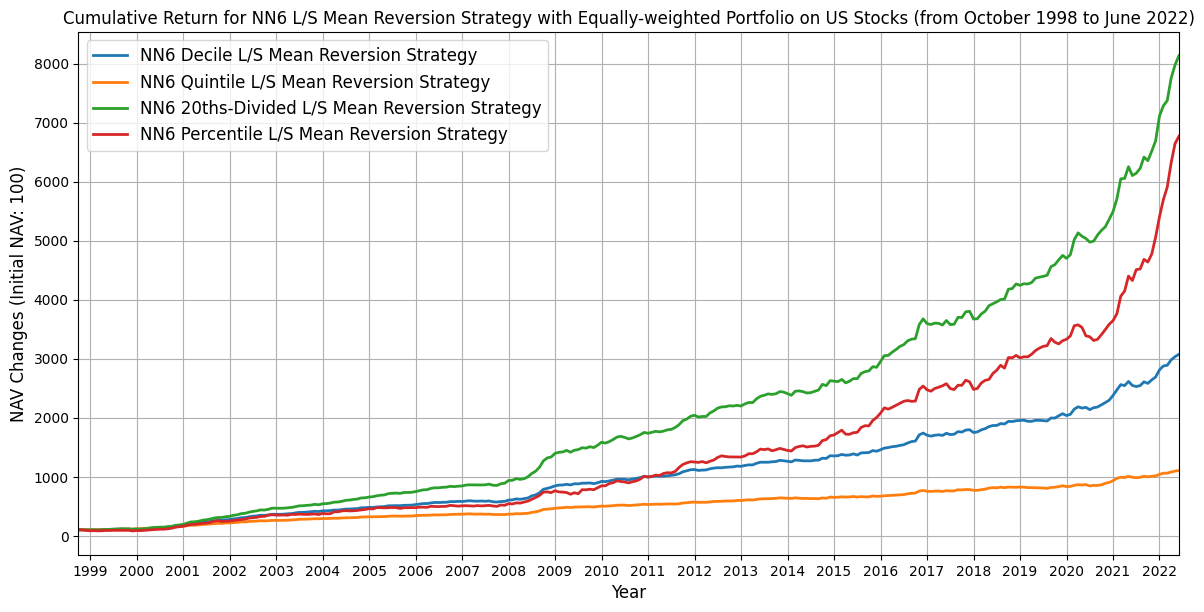

In [190]:
cum_NN6_Q_strategy_return = get_price_df(df_NN6_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_D_strategy_return = get_price_df(df_NN6_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_T_strategy_return = get_price_df(df_NN6_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN6_P_strategy_return = get_price_df(df_NN6_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN6_strategy_return = pd.concat([cum_NN6_D_strategy_return.rename('NN6 Decile L/S Mean Reversion Strategy'),
                                     cum_NN6_Q_strategy_return.rename('NN6 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN6_T_strategy_return.rename('NN6 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN6_P_strategy_return.rename('NN6 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN6_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN6 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)',
          fontsize=12)
plt.show()

In [232]:
# Performance Stats
stats_NN6_Q = get_performance_stats(cum_NN6_Q_strategy_return, rfr=risk_free_rate_df, label='NN6 Quintile (Initial NAV: 100)')
stats_NN6_D = get_performance_stats(cum_NN6_D_strategy_return, rfr=risk_free_rate_df, label='NN6 Decile (Initial NAV: 100)')
stats_NN6_T = get_performance_stats(cum_NN6_T_strategy_return, rfr=risk_free_rate_df, label='NN6 20ths (Initial NAV: 100)')
stats_NN6_P = get_performance_stats(cum_NN6_P_strategy_return, rfr=risk_free_rate_df, label='NN6 Percentile (Initial NAV: 100)')
NN6_stats = pd.concat([stats_NN6_Q, stats_NN6_D, stats_NN6_T, stats_NN6_P], axis=0)
display(NN6_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN6 Quintile (Initial NAV: 100),10.397811,0.107893,0.018682,0.048714,1.831318,0.835081,1.105527,1139.781067,2022-06-30,0.026024,2020-04-30,2020-07-31,2020-11-30,214
NN6 Decile (Initial NAV: 100),29.363385,0.154555,0.018682,0.062840,2.162212,1.105857,2.460501,3036.338456,2022-06-30,0.027412,2021-05-31,2021-07-31,2021-09-30,122
NN6 20ths (Initial NAV: 100),81.700114,0.204307,0.018682,0.077153,2.405934,1.069353,3.005415,8270.011381,2022-06-30,0.036813,2020-04-30,2020-08-31,2020-10-31,184
NN6 Percentile (Initial NAV: 100),76.991437,0.201338,0.018682,0.102170,1.787750,0.198372,2.733569,7799.143664,2022-06-30,0.086608,2016-12-31,2018-02-28,2018-08-31,608


In [44]:
stats2_NN6_Q = get_performance_stats_2(df_NN6_Quintile_Signal, df_returns, df_market_cap, label='NN6 Quintile', model_type='ML')
stats2_NN6_D = get_performance_stats_2(df_NN6_Decile_Signal, df_returns, df_market_cap, label='NN6 Decile', model_type='ML')
stats2_NN6_T = get_performance_stats_2(df_NN6_20_Divided_Signal, df_returns, df_market_cap, label='NN6 20ths', model_type='ML')
stats2_NN6_P = get_performance_stats_2(df_NN6_Percentile_Signal, df_returns, df_market_cap, label='NN6 Percentile', model_type='ML')
NN6_stats2 = pd.concat([stats2_NN6_Q, stats2_NN6_D, stats2_NN6_T, stats2_NN6_P], axis=0)
display(NN6_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN6 Quintile (Long & Short),10.049977,0.008465,3.439555e+10,0.710345,0.092487,-0.078727,0.507694,0.520449,0.496958,295.479310
(Long Position),1212.926721,0.025231,9.260438e+08,0.693103,0.102660,-0.073216,0.568822,0.588790,0.552291,157.696552
(Short Position),-0.950523,-0.010493,6.526417e+10,0.393103,0.066588,-0.073637,0.451536,0.458737,0.445382,138.096552
NN6 Decile (Long & Short),29.727380,0.012091,5.804417e+10,0.748276,0.093942,-0.076178,0.521963,0.539638,0.507266,206.675862
(Long Position),9266.447389,0.032569,7.117526e+08,0.758621,0.103650,-0.064140,0.595626,0.626783,0.570493,118.127586
(Short Position),-0.950554,-0.010495,1.082464e+11,0.386207,0.068607,-0.076026,0.457747,0.465990,0.450710,88.603448
NN6 20ths (Long & Short),80.325080,0.015553,1.008934e+11,0.775862,0.095604,-0.074356,0.540946,0.561434,0.524093,136.824138
(Long Position),81149.446057,0.040460,7.356939e+08,0.844828,0.104103,-0.052620,0.640199,0.688878,0.601869,88.324138
(Short Position),-0.963691,-0.011567,1.825929e+11,0.379310,0.070521,-0.079535,0.460397,0.462409,0.458683,48.524138
NN6 Percentile (Long & Short),66.676883,0.014898,3.494678e+11,0.662069,0.094165,-0.081411,0.569344,0.572651,0.566543,39.455172


In [56]:
cum_NN6_Q_strategy_return_L = get_price_df(df_NN6_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN6_Q_strategy_return_S = get_price_df(df_NN6_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN6_D_strategy_return_L = get_price_df(df_NN6_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN6_D_strategy_return_S = get_price_df(df_NN6_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN6_Q_L = get_performance_stats(cum_NN6_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN6 Quintile L (Initial NAV: 100)')
stats_NN6_Q_S = get_performance_stats(cum_NN6_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN6 Quintile S (Initial NAV: 100)')
stats_NN6_D_L = get_performance_stats(cum_NN6_D_strategy_return_L, rfr=risk_free_rate_df, label='NN6 Decile L (Initial NAV: 100)')
stats_NN6_D_S = get_performance_stats(cum_NN6_D_strategy_return_S, rfr=risk_free_rate_df, label='NN6 Decile S (Initial NAV: 100)')
NN6_stats3 = pd.concat([stats_NN6_Q_L, stats_NN6_Q_S, stats_NN6_D_L, stats_NN6_D_S], axis=0)
display(NN6_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN6 Quintile L (Initial NAV: 100),1212.926721,0.348530,0.018682,0.168218,1.960835,0.384873,0.674600,136132.561362,2021-10-31,0.108276,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN6 Quintile S (Initial NAV: 100),8.535106,0.099600,0.018682,0.175128,0.462049,-0.448651,1.067943,1327.874294,2021-10-31,0.281927,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN6 Decile L (Initial NAV: 100),9266.447389,0.469027,0.018682,0.154067,2.923046,0.686887,1.159688,988511.069856,2022-03-31,0.062484,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN6 Decile S (Initial NAV: 100),7.378462,0.093629,0.018682,0.190106,0.394237,-0.335428,1.535081,1244.106422,2021-10-31,0.326548,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [21]:
validation_date = ['1998-08', '1998-09']

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [25]:
def creating_nn6(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value=21, step=1)
    unit2 = hp.Int('lay1', min_value=1, max_value=21, step=1)
    unit3 = hp.Int('lay2', min_value=1, max_value=21, step=1)
    unit4 = hp.Int('lay3', min_value=1, max_value=21, step=1)
    unit11 = hp.Int('lay4', min_value=1, max_value=21, step=1)
    unit13 = hp.Int('lay5', min_value=1, max_value=21, step=1)
    unit15 = hp.Int('lay6', min_value=1, max_value=21, step=1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit12 = hp.Float('dropout5', min_value=0, max_value=0.7, step=0.1)
    unit14 = hp.Float('dropout6', min_value=0, max_value=0.7, step=0.1)
    unit16 = hp.Float('dropout7', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values=[1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1 = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(unit11, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit12))
    model.add(Dense(unit13, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit14))
    model.add(Dense(unit15, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit16))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn6 = kt.Hyperband(creating_nn6, objective='val_loss', max_epochs=50, project_name='nn6_tuning_1', overwrite=True)
tuner_nn6.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn6.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 12
lay1: 16
lay2: 11
lay3: 11
lay4: 18
lay5: 3
lay6: 18
dropout1: 0.0
dropout2: 0.6
dropout3: 0.6
dropout4: 0.1
dropout5: 0.6
dropout6: 0.0
dropout7: 0.6
regularization: 0.01
dense_activation: relu
learning_rate: 0.001
tuner/epochs: 6
"""

### (3) Feature Importance

In [ ]:
date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

nn6_importances_df = pd.DataFrame(index=feature_names)

for i in list_1:
    # NN6 model
    model_nn6 = Sequential()
    model_nn6.add(Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01), input_shape=(21,)))  # Input layer
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 1
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 2
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 3
    model_nn6.add(Dropout(0.1))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 4
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 5
    model_nn6.add(Dropout(0))
    model_nn6.add(Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))  # hidden layer 6
    model_nn6.add(Dropout(0.6))
    model_nn6.add(Dense(1, activation='linear'))  # Output layer
    model_nn6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i + 7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i + 6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i + 6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn6.fit(X_train, y_train)
    perm_nn6 = PermutationImportance(model_nn6, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
    nn6_importances_1 = pd.Series(perm_nn6.feature_importances_, index=feature_names)
    nn6_f = nn6_importances_1 / abs(nn6_importances_1).sum()
    nn6_importances_df = pd.concat([nn6_importances_df, nn6_f], axis=1)

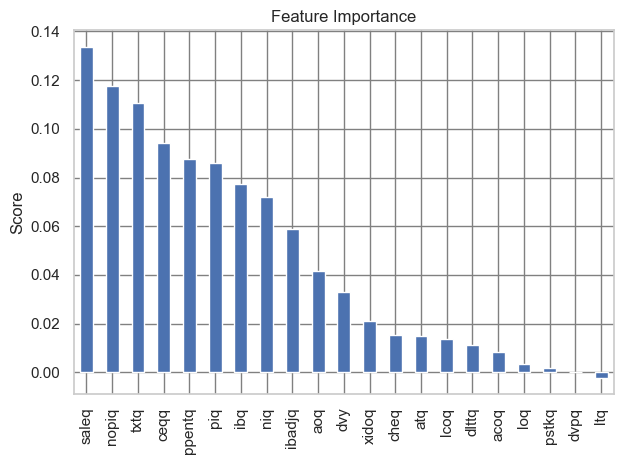

In [17]:
nn6_avg_importance = nn6_importances_df.mean(axis=1).sort_values(ascending=False)
fig, ax4 = plt.subplots()
nn6_avg_importance.plot.bar(ax=ax4)
ax4.set_axisbelow(True)
ax4.grid(color='gray')
ax4.set_title('Feature Importance')
ax4.set_ylabel('Score')
fig.tight_layout()
plt.show()